# Assignment 7 Solutions

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

def linear_regression(sumx,sumy,sumxy,sumx2,n):
    b = (n*sumxy-sumx*sumy)/(n*sumx2-sumx**2)
    xbar = sumx/n
    ybar = sumy/n
    a = ybar - b*xbar
    return a,b
def sigma_regression_summary_stats(sumx,sumy,sumxy,sumx2,sumy2,n,b0,b1):
    t1 = n*b0*b0
    t2 = 2*b0*b1*sumx
    t3 = b1**2*sumx2
    t4 = -2.0*b0*sumy
    t5 = -2.0*b1*sumxy
    t6 = sumy2
    v_error = n - 2

    sigma = np.sqrt(1.0/v_error*(t1+t2+t3+t4+t5+t6))

    return float(sigma)

from scipy.special import gamma

def fpcalc(MS_treatment,MS_error,dof_treatment,dof_error,alpha):

    fSN = float(MS_treatment/MS_error)
    print ("F Signal/Noise = %0.2f " % fSN)

    fdist = stats.f(dof_treatment,dof_error)
    fhigh = fdist.ppf(1-alpha)
    print ("Critical F-value = %0.2f" % (fhigh))

    if (fSN > 1):
        pvalue = (1-fdist.cdf(fSN))
    else:
        pvalue = fdist.cdf(fSN)

    print ("Pvalue = %0.3f" % (pvalue))

    return (fSN,pvalue)

def tukey_calc(xbar,MS_error,n,dof_error,alpha):

    # Tukey's Procedure
    #
    # Step 1:  Calculate the standard error = sqrt(MS_error/n)

    std_error = np.sqrt(MS_error/n)
    print ("Standard Error = %0.3f" % std_error)

    # Step 2:  Order the means from smallest to largest

    print ("Original Xbar = ",xbar)
    xbar_orig = xbar.copy()
    xbar.sort()
    print ("Sorted Xbar = ",xbar)

    # Step 3:  Get the expected number of error bars (sem) between largest and smallest, for the number
    # of means to be compared (a).  For this, we need the studentized range table values q(alpha,dof_error,k) for k=2..a.
    # 
    # http://www.real-statistics.com/statistics-tables/studentized-range-q-table/
    # For this problem, dof_error = 15, alpha = 0.05, k = 2,3,4,5
    #q = np.array([3.014,3.673,4.076,4.367])

    n_means=len(xbar)
    q = q_tukey(n_means,dof_error,alpha)
    print (q)

    # Step 4:  Calculate W = q(k=5)*std_error

    W = q[n_means-2]*std_error

    print ("W = %0.2f" % W)

    # Step 5:  Make pair-wise comparisons

    print (list(xbar_orig))

    print ("i j xbar1 xbar2 Diff Diff_comp Result")
    for i in range(len(xbar)):
        for j in range(len(xbar)):
            if (xbar[j] > xbar[i]):
                diff = (xbar[j] - xbar[i])/std_error
                diff_comp = q[j-i-1]
                if (diff>diff_comp):
                    Result = "Yes"
                else:
                    Result = "No"
                iorig = list(xbar_orig).index(xbar[i])+1
                jorig = list(xbar_orig).index(xbar[j])+1
                print ("%0.0f %0.0f %0.1f %0.1f %0.3f  %0.3f %s" % (iorig,jorig,xbar[i],xbar[j],diff,diff_comp,Result))

def linear_regression(sumx,sumy,sumxy,sumx2,n):
    b0 = (sumx2*sumy-sumx*sumxy)/(n*sumx2-sumx**2)
    b1 = (n*sumxy-sumx*sumy)/(n*sumx2-sumx**2)
    return b0,b1

def sigma_regression_summary_stats(sumx,sumy,sumxy,sumx2,sumy2,n,b0,b1):
    t1 = n*b0*b0
    t2 = 2*b0*b1*sumx
    t3 = b1**2*sumx2
    t4 = -2.0*b0*sumy
    t5 = -2.0*b1*sumxy
    t6 = sumy2
    v_error = n - 2

    sigma = np.sqrt(1.0/v_error*(t1+t2+t3+t4+t5+t6))

    return float(sigma)

def q_tukey(k, v, alpha):

    qarray = []
    for k in range(2,k+1):
        print ("q_tukey: calculating k = ",k)

        dq = 0.003
        qd = np.array(np.arange(0.000,6.000,dq))

        f = []
        fs = []
        found = False

        for i in range(len(qd)):
            q = qd[i]
            prefactor = np.sqrt(2.0*np.pi)*k*(k-1)*v**(v/2.0)/(gamma(v/2.0)*2**(v/2.0-1))
            npts = 100

            xh = 6.0
            xl = 0.0
            dx = (xh-xl)/npts

            x = np.arange(xl,xh,dx)
            x = x.reshape(1,-1)

            ul = -6.0
            uh = 6.0
            du = (uh-ul)/npts

            u = np.arange(ul,uh,du)
            u = u.reshape(-1,1)

            phi_u = stats.norm.pdf(u)
            phi_ux = stats.norm.pdf(u-q*x)
            Phi_u = stats.norm.cdf(u)
            Phi_ux = stats.norm.cdf(u-q*x)
            phi_x = stats.norm.pdf(np.sqrt(v)*x)

            integrand = x**v*phi_x*phi_u*phi_ux*(Phi_u-Phi_ux)**(k-2)*du*dx

            #print ("U integral matrix")
            #print(u,phi_u,phi_ux,Phi_u,Phi_ux,phi_x,x**v,integrand)

            sumux = integrand.sum()

            #print ("U sum")
            #print(sumux)

            #print ("X sum * prefactor")
            #print (sumux*prefactor)

            f.append(sumux*prefactor)

            if (i>0):
                fs.append(f[i]*dq+fs[i-1])
            else:
                fs.append(f[i]*dq)

            if (fs[i]>(1-alpha) and not(found)):
                q_critical = qd[i-1] + ((1-alpha)-fs[i-1])*(qd[i]-qd[i-1])/(fs[i]-fs[i-1])
                print ("q_critical = ",q_critical)
                found = True

            #print(q,f[i],fs[i])

        qarray.append(q_critical)
        plt.scatter(q_critical,(1-alpha))

        f = np.array(f)
        fs = np.array(fs)
        plt.plot(qd,fs)

    qarray=np.array(qarray)
    return qarray

def sem_neq(n1,n2,s1,s2):
    sm = np.sqrt(s1**2/n1+s2**2/n2)
    return float(sm)

def ndof_neq(n1,n2,s1,s2):
    v1 = s1**2/n1
    v2 = s2**2/n2
    dof = (v1+v2)**2/(v1**2/(n1-1)+v2**2/(n2-1))
    return int(dof)

def sem_eq(n1,n2,s1,s2):
    sp = np.sqrt(((n1-1)*s1**2+(n2-1)*s2**2)/(n1+n2-2))
    sm = sp*np.sqrt(1.0/n1+1.0/n2)
    return float(sm)

def ndof_eq(n1,n2,s1,s2):
    dof = n2+n1-2
    return int(dof)


## Question 1

An article on estimating 28-day strength of concrete considered regressing y = 28-day standard-cured strength (psi) against x = accelerated strength (psi). Suppose the equation of the true regression line is y = 1789 + 0.7x.

(a) What is the expected value of 28-day strength when accelerated strength = 2445? 

(b) By how much can we expect 28-day strength to change when accelerated strength increases by 1 psi? 

(c) Answer part (b) for an increase of 108 psi. (Give answer accurate to 1 decimal place.)

(d) Answer part (b) for a decrease of 108 psi. (Give answer accurate to 1 decimal place.) 

In [11]:
m=1.7
b=1797
x=2540
y=m*x+b
print("a:",y)
x=1
y=m*x
print("b:",y)
x=102
y=m*x
print("c:",y)
x=-102
y=m*x
print("d:",y)

a: 6115.0
b: 1.7
c: 173.4
d: -173.4


## Question 2

Suppose that in a certain chemical process the reaction time y (hr) is related to the temperature (°F) in the chamber in which the reaction takes place according to the simple linear regression model with equation y = 4.7 – 0.016x and σ = 0.085.

(a) What is the expected change in reaction time for a 1°F increase in temperature?

What is the expected change in reaction time for a 6°F increase in temperature? (Give answer accurate to 3 decimal places.)
 

(b) What is the expected reaction time when temperature is 170°F? (Give answer accurate to 2 decimal places.) 

What is the expected reaction time when temperature is 190°F? (Give answer accurate to 2 decimal places.)

(c) Suppose five observations are made independently on reaction time, each one for a temperature of 190°F. What is the probability that all five times are between 1.48 and 1.84 hours? (Give answer accurate to 3 decimal places.) 

(d) What is the probability that two independently observed reaction times for temperatures 1° apart are such that the time at the higher temperature exceeds the time at the lower temperature? (Give answer accurate to 3 decimal places.)

In [12]:
m=-.015
b=5.1
sig=.073
x=1
y=m*x
print("a:",y)
x=14
y=m*x
print("a:",y)
x=190
y=m*x+b
print("b:",y)
x=210
y=m*x+b
print("b:",y)

t=stats.t(4,loc=y,scale=sig)
chance=(t.cdf(2.00)-t.cdf(1.90))**5
print(chance)
score=(-m)/(np.sqrt(2)*sig)
n=stats.norm()
print(1-n.cdf(score))

a: -0.015
a: -0.21
b: 2.2499999999999996
b: 1.9499999999999997
0.022687792726277117
0.44223862034735684


## Question 3

The accompanying data on x = current density (mA/cm$^2$) and y = rate of deposition (µm/min) appeared in the article "Plating of 60/40 Tin/Lead Solder for Head Termination Metallurgy" (Plating and Surface Finishing, Jan. 1997: 38-40). Do you agree with the claim by the article's author that "a linear relationship was obtained from the tin-lead rate of deposition as a function of current density"? (Give answer accurate to 3 decimal places.)

x	20	40	60	80
y  	  0.24  	  1.20  	  1.71  	  2.22  

$r^2$ = 

Explain your reasoning.

In [13]:
xijk = np.array([[20,.24],[40,1.2],[60,1.71],[80,2.22]])

df = pd.DataFrame(xijk,columns=['X','Y'])

df.head(1000)
print(df)
result = sm.ols('X ~ Y',df).fit()
print (result.summary())

      X     Y
0  20.0  0.24
1  40.0  1.20
2  60.0  1.71
3  80.0  2.22
                            OLS Regression Results                            
Dep. Variable:                      X   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     68.48
Date:                Fri, 18 Dec 2020   Prob (F-statistic):             0.0143
Time:                        13:07:26   Log-Likelihood:                -10.981
No. Observations:                   4   AIC:                             25.96
Df Residuals:                       2   BIC:                             24.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


## Question 4

A scatter plot along with the least squares line of x = rainfall volume (m3) and y = runoff volume (m3) were given for a particular location. The accompanying values were read from the plot.

(a) Does a scatter plot of the data support the use of the simple linear regression model? 

(b) Calculate point estimates of the slope and intercept of the population regression line. (Give answers accurate to 3 decimal places.)

(c) Calculate a point estimate of the true average runoff volume when rainfall volume is 50. (Give answer accurate to 2 decimal places.) 

(d) Calculate a point estimate of the standard deviation σ. (Give answer accurate to 2 decimal places.) 

(e) What proportion of the observed variation in runoff volume can be attributed to the simple linear regression relationship between runoff and rainfall? (Give answer accurate to 4 decimal places.)

In [14]:

x = np.array([4,12,14,18,23,30,40,45,55,67,72,79,96,112,124])
y = np.array([4,10,13,14,15,25,27,47,38,46,53,72,82,99,105])

df = pd.DataFrame({'x':x, 'y':y})

result = sm.ols('y ~ x',df,).fit()
print (result.summary())

r2 = result.rsquared
r2_reduced = result.rsquared_adj
yint = result.params[0]
slope = result.params[1]


x_prediction = 50
y_prediction = slope*x_prediction + yint
print()
print ("c) y_prediction = %0.1f" % y_prediction)


sumx = x.sum()
sumy = y.sum()
sumx2 = (x*x).sum()
sumxy = (x*y).sum()
sumy2 = (y*y).sum()
n = len(x)

b0,b1=linear_regression(sumx,sumy,sumxy,sumx2,n)
sig=sigma_regression_summary_stats(sumx,sumy,sumxy,sumx2,sumy2,n,b0,b1)
print(sig)
print(r2)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     460.7
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           1.55e-11
Time:                        13:07:26   Log-Likelihood:                -46.227
No. Observations:                  15   AIC:                             96.45
Df Residuals:                      13   BIC:                             97.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9018      2.565     -0.741      0.4

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


## Question 5

The following summary statistics were obtained from a study that used regression analysis to investigate the relationship between pavement deflection and surface temperature of the pavement at various locations on a state highway. Here x = temperature (°F) and y = deflection adjustment factor (y ≥ 0).
n = 17       Σxi = 1448.6       Σyi = 10.57
Σxi 2 = 147414.45       Σxiyi = 987.536
Σyi 2 = 7.8653

(a) Compute eta hat1, eta hat0, and the equation of the estimated regression line. Graph the estimated line. (Do this on paper. Your instructor may ask you to turn in this work. Give answers accurate to 4 decimal places.)
y^^\^ =    seenKey 0.3131	+    seenKey 0.0036  x

(b) What is the estimate of expected change in the deflection adjustment factor when temperature is increased by 1°F? (Give answer accurate to 4 decimal places.) 
   seenKey 0.0036  

(c) Suppose temperature were measured in °C rather than in °F. What would be the estimated regression line? Answer part (b) for an increase of 1°C. [Hint: °F = (9/5)°C + 32; now substitute for the "old x" in terms of the "new x."] (Give answers accurate to 4 decimal places.)
y^^\^ =    seenKey 0.4290	+    seenKey 0.0065  x

(d) If a 200°F surface temperature were within the realm of possibility, would you use the estimated line of part (a) to predict deflection factor for this temperature? Why or why not? 


In [15]:
sumx = 1442
sumy = 10.8
sumx2 = 140832.61
sumxy = 979.748
sumy2 = 7.8711
n = 18

yint, slope = linear_regression(sumx,sumy,sumxy,sumx2,n)

print()
print ("a) y = %0.4f + %0.4f x" % (yint,slope))

x = 1
delta = slope*x
print ()
print ("b) delta = %0.4f" % delta)

# y = yint + slope*x
# y = yint + slope(9/5*x + 32)
# y = yint + slope*32 + slope*9/5 * x

yintF = yint + slope*32
slopeF = slope*9/5
print()
print ("c) y = %0.4f + %0.4f x" % (yintF,slopeF))

y_prediction = yint + slope*200.0
print()
print ("d) y_prediction = %0.4f" % y_prediction)



a) y = 0.2375 + 0.0045 x

b) delta = 0.0045

c) y = 0.3823 + 0.0081 x

d) y_prediction = 1.1425


## Question 6

The following data is representative of that reported in an article on nitrogen emissions, with x = burner area liberation rate (MBtu/hr-ft2) and y = NOx emission rate (ppm).
x	  100	125	125	150	150	200	200	250	250	300	300	350	400	400
y    	  140  	130  	170  	220  	190  	300  	270  	390  	420  	440  	400  	590  	600  	650  
(a) Assuming that the simple linear regression model is valid, obtain the least squares estimate of the true regression line. (Give answers accurate to 2 decimal places.)
y^^\^ =    seenKey -49.35  +    seenKey 1.70  x

(b) What is the estimate of expected NOx emission rate when burner area liberation rate equals 250? (Give answer accurate to 1 decimal place.)

(c) Estimate the amount by which you expect NOx emission rate to change when burner area liberation rate is decreased by 60. (Give answer accurate to 1 decimal place.) 

(d) Would you use the estimated regression line to predict emission rate for a liberation rate of 500? Why or why not?

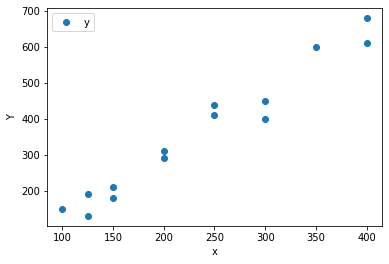

In [16]:
x = np.array([100,125,125,150,150,200,200,250,250,300,300,350,400,400])
y = np.array([150,130,190,210,180,310,290,410,440,450,400,600,610,680])

df = pd.DataFrame({'x':x, 'y':y})

df.plot('x','y',style='o')
plt.ylabel('Y')
plt.show()

In [17]:
result = sm.ols('y ~ x',df,).fit()
print (result.summary())

r2 = result.rsquared
r2_reduced = result.rsquared_adj
yint = result.params[0]
slope = result.params[1]
yintr=round(yint,2)
sloper=round(slope,2)

x_prediction = 245
y_prediction = sloper*x_prediction + yintr
print()
print ("b) y_prediction = %0.2f" % y_prediction)

print()
print ("c) delta = %0.1f" % (slope*-40))

sumx = x.sum()
sumy=y.sum()
x2=x*x


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     287.4
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           9.51e-10
Time:                        13:07:26   Log-Likelihood:                -69.662
No. Observations:                  14   AIC:                             143.3
Df Residuals:                      12   BIC:                             144.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -49.7569     26.241     -1.896      0.0

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


In [67]:
print("Q1")
n=10
p=.23
npr=int(n*p)
B=stats.binom(npr,.5)
print(B.cdf(2)-B.cdf(1))
print()

Q1
0.25



In [81]:
print("Q2")
sig=10
u=75
n=25
df = n -1
sem = sig/np.sqrt(n)
X=stats.norm(loc=u,scale=sig)
z=stats.norm()
a=.01
zlow = z.ppf(a/2)
c_interval = stats.t.interval(0.99, df)

print ("(%0.2f, %0.2f)" % c_interval)
print ("a: %.2f"%((72.3-u)/sem))
tdist = stats.t(df)

pvalue = 2.0*tdist.cdf(-np.abs(tvalue))
print ("P-value = %0.7f" % pvalue)
print()

Q2
(-2.80, 2.80)
a: -1.35
P-value = 0.0108139



In [46]:
print("Q3")
n = 116
df = n -1
xbar = .77
s = .39
sem = s/np.sqrt(n)
c_interval = stats.t.interval(0.99, df, loc=xbar, scale=sem)

print ("(%0.3f, %0.3f)" % c_interval)
print()

Q3
(0.675, 0.865)



In [52]:
print("Q4")
n = 100
df = n - 1
xbar = 50
s = 1

sem = s/np.sqrt(n)
X=stats.norm(loc=xbar,scale=sem)
print(X.cdf(50.1)-X.cdf(49.9))
X=stats.norm(loc=xbar-.2,scale=sem)
print(X.cdf(50.1)-X.cdf(49.9))
print()

Q4
0.6826894921370927
0.15730535589982375



In [60]:
print("Q5")
n1=39
n2=30
x1=18.81
x2=16.65
s1=1.6
s2=1.4
a=.01

df = ndof_neq(n1,n2,s1,s2)
sm = sem_neq(n1,n2,s1,s2)

tvalue = (x1-x2)/sm

print ("DF, T = %0.0f, %0.2f" % (df,tvalue))

tdist = stats.t(df)

pvalue = 2.0*tdist.cdf(-np.abs(tvalue))
print ("P-value = %0.7f" % pvalue)
tvalue = (1)/sm
pvalue = 2.0*tdist.cdf(-np.abs(tvalue))
print ("P-value = %0.7f" % pvalue)
print()

Q5
DF, T = 65, 5.97
P-value = 0.0000001
P-value = 0.0074375



In [ ]:
print("Q6")
a = 3
N=25+27+28
dof_total = N - 1
dof_treatment = a - 1
dof_error = dof_total - dof_treatment
SS_total = 1125.13
MS_treatment = 77.73
SS_treatment = MS_treatment*dof_treatment

SS_error = SS_total - SS_treatment
MS_error = SS_error/dof_error

fSN = MS_treatment/MS_error

alpha = 0.01

fdist = stats.f(dof_treatment,dof_error)
fhigh = fdist.ppf(1-alpha)

if (fSN > 1):
    pvalue = (1-fdist.cdf(fSN))
else:
    pvalue = fdist.cdf(fSN)

# print table

print ("Source     df     Sum of Squares     Mean Square     f     P-value")
print ("Groups     %0.0f       %0.2f           %0.2f       %0.2f    %0.3f" %(dof_treatment,SS_treatment,MS_treatment,fSN,pvalue))
print ("Error      %0.0f      %0.2f          %0.2f" %(dof_error,SS_error,MS_error))
print ("Total      %0.0f      %0.2f" %(dof_total,SS_total))
print()

In [ ]:
print("Q7")
print()

In [ ]:
print("Q8")
a = 3
b = 4
n = 3

N = n*a*b

v_total = N - 1
v_a = a - 1
v_b = b - 1
v_ab = (a-1)*(b-1)
v_treatment = v_a + v_b + v_ab
v_error = v_total - v_treatment

print ("v_a, v_b, v_ab, v_error, v_total = ",v_a, v_b, v_ab, v_error, v_total)
SS_a = 30341.9
SS_b = 35438.1
SS_error = 98653.1
SS_total = 206391.2

SS_ab = SS_total - SS_a - SS_b - SS_error

print ("SS_ab = %0.1f" % SS_ab)
MS_a = SS_a/v_a
MS_b = SS_b/v_b
MS_ab = SS_ab/v_ab
MS_error = SS_error/v_error

fSN_a = MS_a/MS_error
fSN_b = MS_b/MS_error
fSN_ab = MS_ab/MS_error

print ("F Signal/Noise A = %0.2f " % fSN_a)

alpha = 0.05

fdist_a = stats.f(v_a,v_error)
fhigh_a = fdist_a.ppf(1-alpha)

print ("Critical F-value A = %0.2f" % (fhigh_a))

if (fSN_a > 1):
    pvalue_a = (1-fdist_a.cdf(fSN_a))
else:
    pvalue_a = fdist_a.cdf(fSN_a)
    
print ("Pvalue A = %0.3f" % (pvalue_a))


print ("F Signal/Noise B = %0.2f " % fSN_b)

fdist_b = stats.f(v_b,v_error)
fhigh_b = fdist_b.ppf(1-alpha)

print ("Critical F-value B = %0.2f" % (fhigh_b))

if (fSN_b > 1):
    pvalue_b = (1-fdist_b.cdf(fSN_b))
else:
    pvalue_b = fdist_b.cdf(fSN_b)
    
print ("Pvalue B = %0.3f" % (pvalue_b))

print ("F Signal/Noise AB = %0.2f " % fSN_ab)

fdist_ab = stats.f(v_ab,v_error)
fhigh_ab = fdist_ab.ppf(1-alpha)

print ("Critical F-value AB = %0.2f" % (fhigh_ab))

if (fSN_ab > 1):
    pvalue_ab = (1-fdist_ab.cdf(fSN_ab))
else:
    pvalue_ab = fdist_ab.cdf(fSN_ab)
    
print ("Pvalue AB = %0.3f" % (pvalue_ab))

# Print table
print()
print ("Source     df     Sum of Squares   Mean Square       f     P-value")
print ("A          %0.0f       %0.2f           %0.2f       %0.2f    %0.3f" %(v_a,SS_a,MS_a,fSN_a,pvalue_a))
print ("B          %0.0f       %0.2f           %0.2f       %0.2f    %0.3f" %(v_b,SS_b,MS_b,fSN_b,pvalue_b))
print ("AB         %0.0f       %0.2f            %0.2f       %0.2f    %0.3f" %(v_ab,SS_ab,MS_ab,fSN_ab,pvalue_ab))
print ("Error      %0.0f      %0.2f            %0.2f" %(v_error,SS_error,MS_error))
print ("Total      %0.0f     %0.2f" %(v_total,SS_total))

xbar = np.array([4010.88,4029.10,3960.02])
dof_error = v_error
alpha = 0.05
n=N/len(xbar)
tukey_calc(xbar,MS_error,n,dof_error,alpha)


print()

In [ ]:
print("Q9")
xijk = np.array([[280,1,1],[290,1,1],[285,1,1],[300,1,2],[310,1,2],[295,1,2],[270,1,3],[285,1,3],[290,1,3],
                [230,2,1],[235,2,1],[240,2,1],[260,2,2],[240,2,2],[235,2,2],[220,2,3],[225,2,3],[230,2,3]])
df = pd.DataFrame(xijk,columns=['value','A','B'])

formula = 'value ~ C(A) + C(B) +C(A):C(B)'
lm = sm.ols(formula,df).fit()
anovaResults = anova_lm(lm)
print (anovaResults)
alpha = .01
fdist_a = stats.f(1,12)
fhigh_a = fdist_a.ppf(1-alpha)
print ("Critical F-value A = %0.2f" % (fhigh_a))
fdist_a = stats.f(2,12)
fhigh_a = fdist_a.ppf(1-alpha)
print ("Critical F-value B = %0.2f" % (fhigh_a))
fdist_a = stats.f(2,12)
fhigh_a = fdist_a.ppf(1-alpha)
print ("Critical F-value AB = %0.2f" % (fhigh_a))
print()